In [1]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from elasticsearch import Elasticsearch, exceptions as es_exceptions
matplotlib.rc('font', **{'size': 15})

#Create instance of ElasticSearch using the Atlas host server
es = Elasticsearch(hosts=[{'host':'es-atlas.cern.ch', 'port':9202}],
                   http_auth=('es-atlas', 'v~$&<J8/cG9]*eQ@'),
                   timeout=60)

In [2]:
import ast
import time
import numpy as np
def get_ddm_data(src,dst,start,end,field):
    queryTemplate = '''{
      "size": 0,
      "query": {
        "filtered": {
          "query": {
            "query_string": {
              "query": "src:%s AND dst:%s",
              "analyze_wildcard": True
            }
          },
          "filter": {
            "bool": {
              "must": [
                {
                  "range": {
                    "timestamp": {
                      "gte": %i,
                      "lte": %i,
                      "format": "epoch_millis"
                    }
                  }
                }
              ],
              "must_not": []
            }
          }
        }
      },
      "aggs": {
        "2": {
          "date_histogram": {
            "field": "timestamp",
            "interval": "1h",
            "time_zone": "Europe/Berlin",
            "min_doc_count": 1,
            "extended_bounds": {
              "min": %i,
              "max": %i
            }
          },
          "aggs": {
            "1": {
              "avg": {
                "field": "%s"
              }
            }
          }
        }
      }
    }'''
    query = ast.literal_eval(queryTemplate%(src,dst,start,end,start,end,field))
    response = es.search(index="atlas_ddm-metrics*", body=query, request_timeout=600)
    fieldData = []
    timestamp = []

    for r in response['aggregations']['2']['buckets']:
        fieldData.append(r['1']['value'])
        timestamp.append(r['key'])
    
    #Replace None values with NaNs
    fieldData = np.array(fieldData,dtype=np.float)
    timestamp = np.array(timestamp,dtype=np.float)
    return fieldData,timestamp

In [42]:
currentMilliTime = int(round(time.time()*1000))
milliWeek = 7*24*60*60*1000
milliTwoWeek = 2*7*24*60*60*1000
milliMonth = 30*24*60*60*1000
milliDay = 24*60*60*1000
milliHour = 60*60*1000

start = currentMilliTime - milliTwoWeek
end = currentMilliTime

src = 'SARA-MATRIX'
dst = 'BNL-ATLAS'

#Get field values
print('Getting queued and done fields...')
queuedTotal,queuedTimestamp = get_ddm_data(src,dst,start,end,'queued-total')
queuedUserSubscriptions,_ = get_ddm_data(src,dst,start,end,'queued-User_Subscriptions')
doneTotal1h,queuedTimestamp = get_ddm_data(src,dst,start,end,'done-total-1h')
doneUserSubscriptions1h,_ = get_ddm_data(src,dst,start,end,'done-User_Subscriptions-1h')
doneTotal6h,_ = get_ddm_data(src,dst,start,end,'done-total-6h')
doneUserSubscriptions6h,_ = get_ddm_data(src,dst,start,end,'done-User_Subscriptions-6h')

print('Getting packetloss and latency fields...')
packetLoss,_ = get_ddm_data(src,dst,start,end,'packetloss')
latency,_ = get_ddm_data(src,dst,start,end,'latency')
print('Getting throughput fields...')

mbpsFax1d,_ = get_ddm_data(src,dst,start,end,'mbps-fax-1d')
mbpsFts1d,_ = get_ddm_data(src,dst,start,end,'mbps-fts-1d')
mbpsDash1d,_ = get_ddm_data(src,dst,start,end,'mbps-dashb-1d')
mbpsFax1h,_ = get_ddm_data(src,dst,start,end,'mbps-fax-1h')
mbpsFts1h,_ = get_ddm_data(src,dst,start,end,'mbps-fts-1h')
mbpsDash1h,_ = get_ddm_data(src,dst,start,end,'mbps-dashb-1h')


Getting queued and done fields...
Getting packetloss and latency fields...
Getting throughput fields...


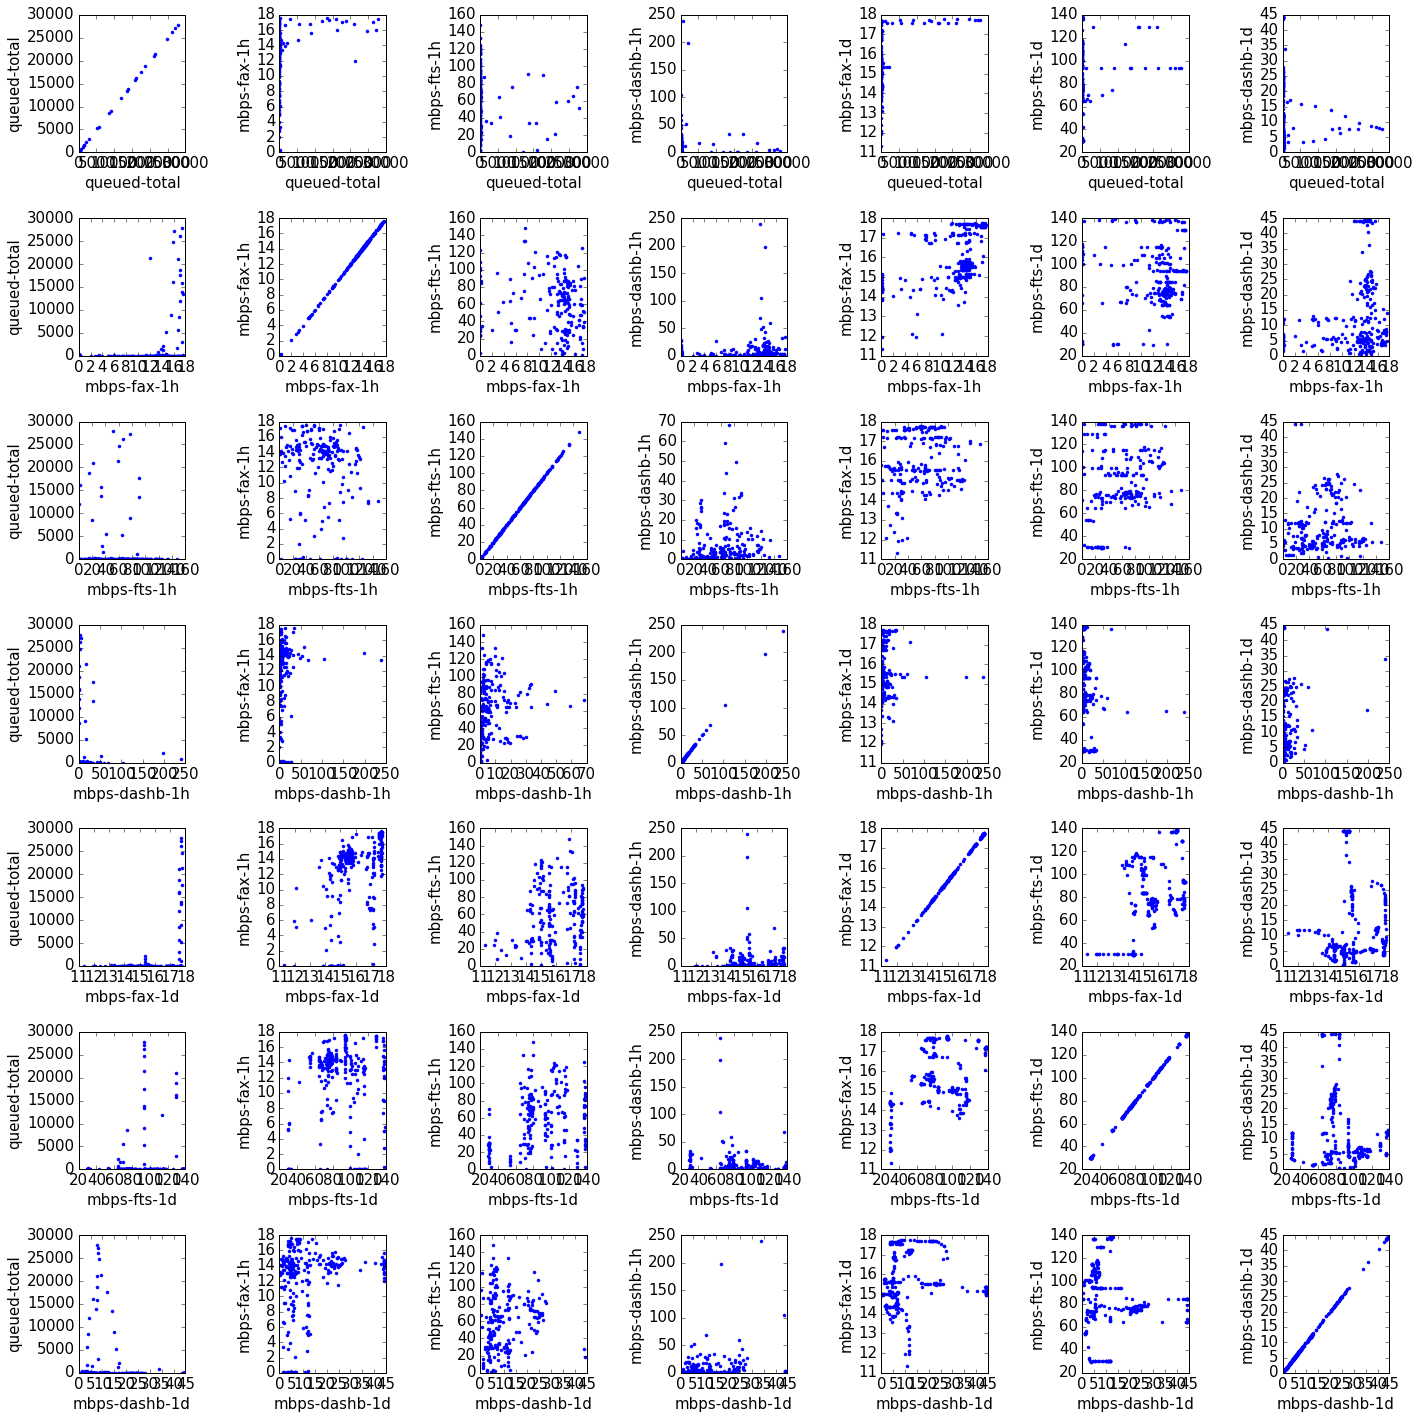

In [38]:
menu = [queuedTotal,mbpsFax1h,mbpsFts1h,mbpsDash1h,mbpsFax1d,mbpsFts1d,mbpsDash1d]
#menu = [queuedTotal/np.nanmean(queuedTotal),mbpsFax/np.nanmean(mbpsFax),mbpsFts/np.nanmean(mbpsFts),
#        mbpsDash/np.nanmean(mbpsDash)]
menuName = ['queued-total','mbps-fax-1h','mbps-fts-1h',
            'mbps-dashb-1h','mbps-fax-1d','mbps-fts-1d','mbps-dashb-1d']
dim = len(menu)

plt.figure(figsize = (20,20))
ind = 0
for i in range(dim):
    for j in range(dim):
        ind +=1
        plt.subplot(dim,dim,ind)
        plt.plot(menu[i],menu[j],'b.')
        plt.xlabel(menuName[i])
        plt.ylabel(menuName[j])
plt.tight_layout()

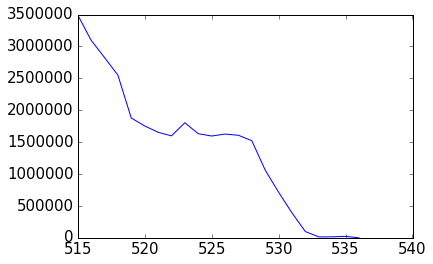

In [94]:
from scipy import signal, fftpack
c = signal.correlate(queuedTotal,doneTotal6h)
plt.plot(c)

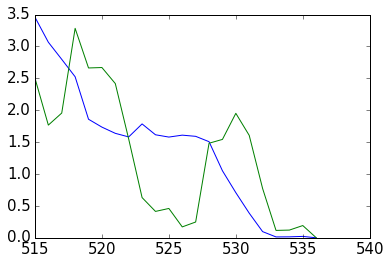

In [105]:
c = signal.correlate(queuedTotal,doneTotal6h)
c = c/np.nanstd(c)
d = signal.correlate(queuedTotal,doneTotal1h)
d = d/np.nanstd(d)
plt.plot(c)
plt.plot(d)

In [ ]:
from scipy.optimize import curve_fit

def func(x,b):
    return x + b


xdata = np.array([0,0,0,0,0,0,0,1,2,3,2,1,2,3,1,4,1])
ydata = np.array([0,0,0,0,0,1,2,3,2,1,2,3,1,4,1,1,2])

popt,pcov = curve_fit(func,xdata,ydata)
plt.plot(ydata,'g')

plt.plot((xdata+popt[0]),'r')